<a href="https://colab.research.google.com/github/Rishsing73/deep-learning/blob/main/gradcam_visualize_your_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<link rel="preconnect" href="https://fonts.gstatic.com">
<link href="https://fonts.googleapis.com/css2?family=Kanit&display=swap" rel="stylesheet">

<h1 style="text-align:center; font-family: 'Kanit', sans-serif;"> Visualize what your CNN Learns</h1>

In [62]:
# !pip install timm
# !pip install grad-cam

In [63]:
import os
import cv2
import timm
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
from torch.autograd import Function
from torchvision import transforms

plt.rcParams["figure.figsize"] = (20,20)

### The following code for Grad-CAM and Guided Backpropagation is borrowed from this amazing repository [https://github.com/jacobgil/pytorch-grad-cam](https://github.com/jacobgil/pytorch-grad-cam)

In [65]:
# from google.colab import drive
# drive.mount('/content/drive')

Download the model using timm

In [66]:
model = timm.create_model('resnet18', pretrained=True)
model.eval()
use_cuda = torch.cuda.is_available()
use_cuda

True

### Uncomment the following Code to get random images

In [67]:
model.layer4[-1] # just checking

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_block): Identity()
  (act1): ReLU(inplace=True)
  (aa): Identity()
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
)

# Let's Visualize the 6th Convolutional Block

In [70]:
from pytorch_grad_cam import GradCAM,  GradCAMPlusPlus, GuidedBackpropReLUModel #2 libraries for heatmap
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget #either define output class or leave it None
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image

In [69]:
help(ClassifierOutputTarget)

Help on class ClassifierOutputTarget in module pytorch_grad_cam.utils.model_targets:

class ClassifierOutputTarget(builtins.object)
 |  ClassifierOutputTarget(category)
 |  
 |  Methods defined here:
 |  
 |  __call__(self, model_output)
 |      Call self as a function.
 |  
 |  __init__(self, category)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



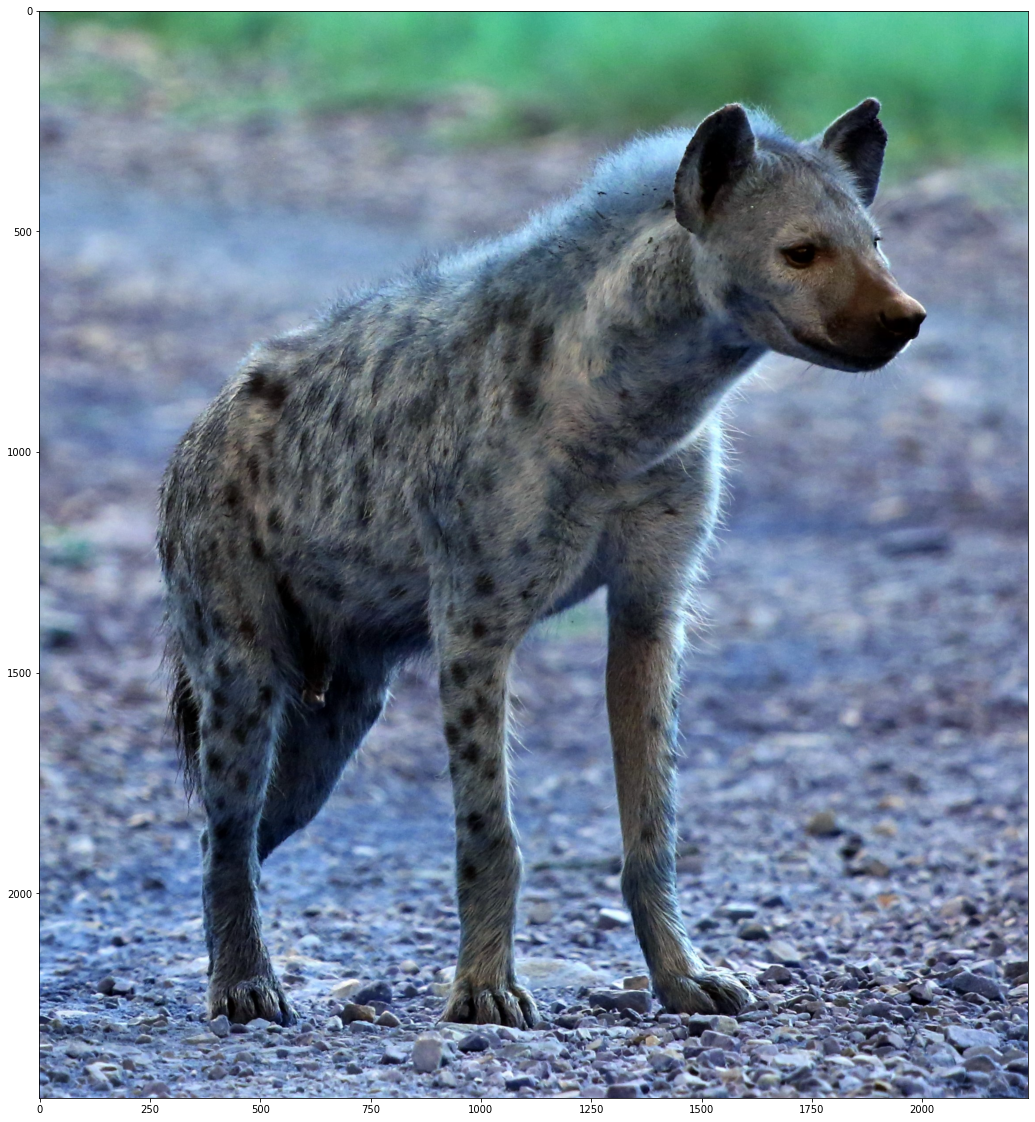

In [71]:
## image was uploaded before hand
img  = cv2.imread('./hyena.jpg')
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.float32(img) / 255
input_img = preprocess_image(img)


In [85]:
target_layers = [model.layer4[-1]] # define the target layer or iterate through many (it will average)


# for gradcam
cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=use_cuda)
targets = [ClassifierOutputTarget(276)] # we can leave it None as well
grayscale_cam = cam(input_tensor=input_img, targets=targets)

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)
grayscale = cam(input_tensor=input_img, targets=targets)


In [86]:
grayplus = grayscale_cam[0, :] #for single image squeezing it
grayplus = cv2.resize(grayplus, (img.shape[1], img.shape[0])) #resizing the heatmap
camplusplus = show_cam_on_image(img, grayplus,use_rgb=True ) #merging them together


gray = grayscale[0, :] #for single image squeezing it
gray = cv2.resize(gray, (img.shape[1], img.shape[0])) #resizing the heatmap
cam = show_cam_on_image(img, gray,use_rgb=True )
# plt.imshow(cam) #just for cam

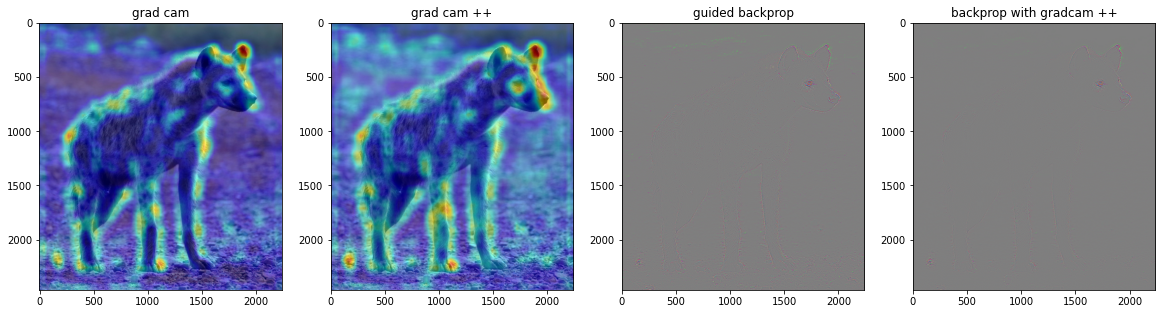

In [87]:
gb_model = GuidedBackpropReLUModel(model=model, use_cuda=use_cuda) # for guided backpropogation
gb = gb_model(input_img, target_category=None)
# gb = gb.transpose((1, 2, 0))


cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
cam_re = cam_mask[0, :] #squeezing
cam_gb = deprocess_image(cam_re*gb)
gb = deprocess_image(gb)

fig, ax = plt.subplots(1,4)
ax[0].title.set_text('grad cam')
ax[1].title.set_text('grad cam ++')
ax[2].title.set_text('guided backprop')
ax[3].title.set_text('backprop with gradcam ++')
ax[0].imshow(cam)
ax[1].imshow(camplusplus)
ax[2].imshow(gb)
ax[3].imshow(cam_gb);

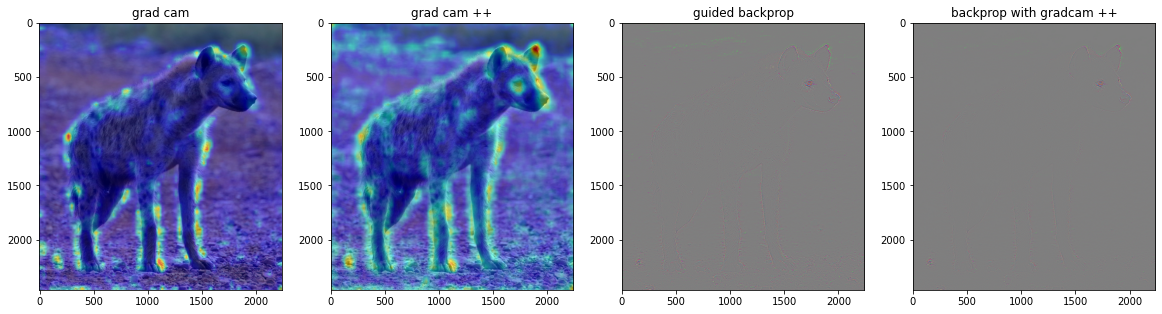

In [84]:
# guided backprop with multiple  layers gradcam


gb_model = GuidedBackpropReLUModel(model=model, use_cuda=use_cuda) # for guided backpropogation
gb = gb_model(input_img, target_category=None)
# gb = gb.transpose((1, 2, 0))


cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
cam_re = cam_mask[0, :] #squeezing
cam_gb = deprocess_image(cam_re*gb)
gb = deprocess_image(gb)

fig, ax = plt.subplots(1,4)
ax[0].title.set_text('grad cam')
ax[1].title.set_text('grad cam ++')
ax[2].title.set_text('guided backprop')
ax[3].title.set_text('backprop with gradcam ++')
ax[0].imshow(cam)
ax[1].imshow(camplusplus)
ax[2].imshow(gb)
ax[3].imshow(cam_gb);